# Guided Example: Spam Filter

The dataset we'll work with is UC Irvine's [SMS spam dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

This dataset has a few nice attributes. Firstly, it's pre-labelled, which is great for our purposes as we don't have to make our own spam/ham labels ('ham' being the common term to denote a message that is not spam). Secondly, the dataset is relatively small, which will allow us to show off one of the great things about Naive Bayes, its ability to train on relatively little data while achieving reasonable accuracy. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [3]:
sms_raw.head()

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms_raw['spam'].value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

At the most obvious level, a feature from the message can be whether it contains a given word. Let's add those columns to our dataframe. The words chosen below are simply intuited as possibly having something to do with spam. Try some of your own ideas too!

In [5]:
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [6]:
sms_raw.head()

,spam,message,click,offer,winner,buy,free,cash,urgent
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False


In [7]:
sms_raw['allcaps'] = sms_raw.message.str.isupper()

In [8]:
sms_raw.head()

,spam,message,click,offer,winner,buy,free,cash,urgent,allcaps
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False


Let's turn the spam column into a boolean so we can easily do some statistics to prepare for modeling.

In [9]:
sms_raw['spam'] = (sms_raw['spam'] == 'spam')
# Note that if you run this cell a second time everything will become false.
# So... Don't.

In [10]:
sms_raw.head()

,spam,message,click,offer,winner,buy,free,cash,urgent,allcaps
0,False,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False
1,False,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False,False
3,False,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False
4,False,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False


One of the main assumptions of Naive Bayes is that the variables fed into the model are independent of each other. Let's check to see how true that is in this case using Pandas' built in correlation matrix function, corr(), and the heatmap from seaborn.

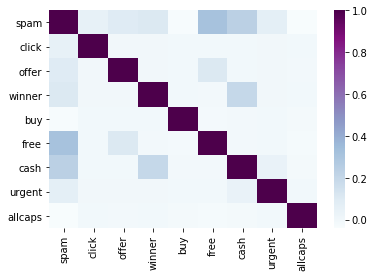

In [11]:
sns.heatmap(sms_raw.corr(), cmap='BuPu')

That is actually a great looking plot for us. Most of the words show strong independence from each other. The only exceptions are free:offer and cash:winner. For now, let's keep everything in the dataset.

Before we actually run the model we have to build out our training data. SKLearn required you to specify an outcome (y or dependent variable) and your inputs (x or independent variables). We'll do that below under the titles `data` and `target`.

In [12]:
# x or independent variables
data = sms_raw[keywords + ['allcaps']]

# y or dependent variables
target = sms_raw['spam']

In [13]:
target.head()

0    False
1    False
2     True
3    False
4    False
Name: spam, dtype: bool

In [14]:
data.head()

,click,offer,winner,buy,free,cash,urgent,allcaps
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [15]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

y_pred = bnb.fit(data,target).predict(data) 

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 5572 points : 604


# Unit 2.3.1 Accuracy and Error Types

## Success Rate
Target = Actual outcomes (spam or ham). y-pred is predicted outcomes from our classifer.  Both are ordered arrays with the results from each row of the dataframe.  When the two agree, our model worked! Disagree, and our model was incorrect.

The most basic measure of success, then, is how odten our model was correct.  This is called **accuracy** and is generally a rate or percentage.  

In [16]:
1 - ((target != y_pred).sum() / data.shape[0])

0.89160086145010764

The spam calssifier has a 89.16% successrate.

Success rate on its own is insignificant.
1. Errors are not created equal.  For example, keeping a spam message (false positive) is not as egregious as marking a real message as spam (false negative).  Knowing more about the kinds of errors you're generating can be very useful.
2. Understanding how model is failing can be key to improving it.  

## Confusion Matrix
A confusion matrix shows the count of each possible permutation of target and prediction.  

SKLearn has a built in confusion matrix function.

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[4770,   55],
       [ 549,  198]])

The columns are prediciton and the rows are actual.

We learn the majority of our error is coming from times where we failed to identify a spam message. 549 of our 604 errors are from failing to identify spam. So we need to get a little bit better at identifying spam messages.

Let's assume our goal is to identify spam (rather than identify ham).

Firstly, when we talk about errors in a binary classifier (where there are only two outcomes) we're generally referring to two kinds of errors. A __false positive__ is when we identify something as spam that is not. In this case we had 55 of these. This is sometimes also called a "Type I Error" or a "false alarm".

A __false negative__ is therefore when we mistakenly identify something as not spam when it is. We had 549 of these. This is also called a "Type II Error" or a "miss".

This also brings us to a conversation of sensitivity vs specificity.

__Sensitivity__ is the percentage of positives correctly identified, in our case 198/747 or 27%. This shows how good we are at catching positives, or how sensitive our model is to identifying positives.

__Specificity__ is just the opposite, the percentage of negatives correctly identified, 4770/4825 or 99%.

Again this confirms that we're not great at identifying spam, though we do label ham quite accurately. You should get familiar with these terms as in the practicing world they will often be used with little explanation and you will be expected to understand them.

# Unit 2.3.3 - In Sample evaluation and cross validation

**Holdout groups** are data reserved for testing purposes.  

In [23]:
# Getting test sample set
sms_70 = sms_raw.sample(frac=0.7)

# Setting up the rest as the holdout group
holdout = sms_raw.loc[~sms_raw.index.isin(sms_70.index)]

In [24]:
data = sms_70[keywords]
target = sms_70['spam']

In [28]:
# Building model with 70% of data.
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 3900 points : 431


In [27]:
confusion_matrix(target, y_pred)

array([[3328,   31],
       [ 400,  141]])

In [30]:
print('Sensitivity: ' + str(141/(400+141)))
print('Specificity: ' + str(3328/(3328+31)))

Sensitivity: 0.26062846580406657
Specificity: 0.9907710628163143


# How do you run model on holdout group?!?!?!
